<a href="https://colab.research.google.com/github/DotStarMoney/NBD/blob/main/synthetic_time_series_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import math
import random as rng
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

In [6]:
def break_pattern(height: int = 5, width: int = 5, 
                  multiplier: int = 6, shapes_n: int = 100) -> np.ndarray:
  """Generates a boolean image with random spatial correlations.
  
  The output will have shape (height, width).
  """
  landscape_w = width * multiplier
  landscape_h = height * multiplier
  landscape = Image.new('1', (landscape_w, landscape_h))
  drawscape = ImageDraw.Draw(landscape)
  for _ in range(shapes_n):
    shape_type = rng.randint(0, 1)

    if shape_type == 0:  # pixel
      drawscape.point(
          (rng.randint(0, landscape_w - 1), 
           rng.randint(0, landscape_h - 1)), fill=rng.randint(0, 1))
    elif shape_type == 1:  # ellipse
      drawscape.ellipse(
          [(rng.randint(0, landscape_w - 1), 
            rng.randint(0, landscape_h - 1)), 
           (rng.randint(0, landscape_w - 1), 
            rng.randint(0, landscape_h - 1))], 
          fill=[0, 1, None][rng.randint(0, 2)],
          outline=[0, 1, None][rng.randint(0, 2)])
  
  crop_x = rng.randint(0, landscape_w - width)
  crop_y = rng.randint(0, landscape_h - height)
  landscape = landscape.crop(
      (crop_x, crop_y, crop_x + width, crop_y + height))

  return np.array(landscape).astype(bool)


def create_tension_mu(tension_max: float = 8):
  tension_mu = rng.random() * tension_max
  return (1.0 / tension_mu) if rng.randint(0, 1) == 1 else tension_mu


def create_spine_fn(start_inc: int, end_exc: int, tension_max: float = 8):
  start_y = rng.random()
  end_y = rng.random()
  tension_mu = create_tension_mu(tension_max)
  def spine_fn(x):
    return (start_y + (end_y - start_y) 
        * (((x - start_inc) / (end_exc - start_inc)) ** tension_mu))

  return spine_fn


def create_noise_fn(harmonics: List[Tuple[float, float]], 
                    tension_max: float = 8, min_sigma: float = 0, 
                    max_sigma: float = 0.1, max_amplitude: float = 0.2):
  harmonic_stats = []
  for harmonic in harmonics:
    # Amplitude and Squeesh
    #
    # If the first harmonic, don't handicap the amplitude
    amplitude = max_amplitude
    if harmonic[2] == 0:
      squeesh = 1
    elif harmonic[2] == 1:
      squeesh = 2
    else:
      squeesh = 2
      amplitude *= 0.5

    harmonic_stats.append((rng.random() ** squeesh * amplitude, 
                           create_tension_mu(tension_max)))
  
  gaussian_noise_sigma = min_sigma + rng.random() * (max_sigma - min_sigma)

  def noise_fn(x):
    x_harmonic = 0
    for i in range(len(harmonic_stats)):
      amplitude, squeesh, = harmonic_stats[i]
      frequency, phase, slow = harmonics[i]
      x_sin = (1.0 + math.sin(x * frequency + phase)) * 0.5

      # If the slow harmonic, don't squeesh
      if slow == 2:
        squeesh = 1.0
      x_harmonic += amplitude * 2.0 * ((x_sin ** squeesh) - 0.5)

    x_harmonic += rng.gauss(0, gaussian_noise_sigma)

    return x_harmonic

  return noise_fn


def random_frequency(low_days: float, high_days: float):
  return math.pi * 2 / (rng.random() * (high_days - low_days) + low_days)


YEAR_DAYS = 365


def generate_ts(breaks: np.ndarray, depth: int, day_freq_variation: float = 60,
                outlier_prob: float = 0.04, max_distance: int = YEAR_DAYS):
  bounds = []
  for i in range(len(breaks) - 1):
    low = breaks[i]
    high = breaks[i + 1]  
    bounds.append((low, high))

  harmonics = []
  # Base harmonic: between 365 - 30 and 365 + 30 day period.
  harmonics.append((random_frequency(YEAR_DAYS - 30, YEAR_DAYS + 30),
                    math.pi * 2 * rng.random(), 0))
  # Fast harmonic: between 60 and 365 day period.
  harmonics.append((random_frequency(60, YEAR_DAYS),
                    math.pi * 2 * rng.random(), 1))
  # 20% change for a slow harmonic
  if rng.randint(0, 5) == 0:
    # Slow Harmonic between 2 and 5 year period.
    harmonics.append((random_frequency(YEAR_DAYS * 2, YEAR_DAYS * 5),
                      math.pi * 2 * rng.random(), 2))

  spine_fns = []
  noise_fns = []
  for low, high in bounds:
    spine_fns.append(create_spine_fn(low, high))
    noise_fns.append(create_noise_fn(harmonics))

  current_seg = 0
  spine = np.zeros([depth])
  noise = np.zeros([depth])
  for x in range(depth):
    if x >= bounds[current_seg][1]:
      current_seg += 1
    
    spine[x] = spine_fns[current_seg](x)
    noise[x] = noise_fns[current_seg](x)

  raw = spine + noise
  
  if rng.randint(0, 4) == 0:
    low = np.min(raw)
    high = np.max(raw)
  else:
    edge = rng.random() * 0.2
    low = -edge
    high = 1.0 + edge

  raw = (raw - low) / (high - low)
  spine = (spine - low) / (high - low)

  for x in range(depth):
    if rng.random() < outlier_prob:
      raw[x] += ((rng.random() * 2.0) - 1.0) * 3

  raw = np.clip(raw, 0, 1)

  distance_breaks = breaks[1:-1]
  if distance_breaks.size == 0:
    distance = np.ones_like(spine)
  else:
    distance = np.zeros_like(spine)
    current_break = 0
    for x in range(depth):
      if ((current_break < (len(distance_breaks) - 1)) 
          and ((distance_breaks[current_break + 1] - x) 
              < (x - distance_breaks[current_break]))):
        current_break += 1
      distance[x] = min(abs(distance_breaks[current_break] - x) / max_distance,
                        1.0)
  
  conv_spine = np.convolve(spine, np.ones([15]), mode='same')
  conv_count = np.convolve(np.ones_like(spine), np.ones([15]), mode='same')
  spine = conv_spine / conv_count

  return spine, distance, raw


def fake_timeseries_pattern(depth: int = 4096, height: int = 5, width: int = 5, 
                            event_prob: float = 0.0015, 
                            unmask_prob_min: float = 0.08, 
                            unmask_prob_max: float = 0.12,
                            min_event_period: int = 365, 
                            spine_prob: float = 0.01):
  """Generates a fake landsat time series patch.
  
  The likelihood of a given day yielding a valid observation is about 2.5%. The 
  average number of breaks every 11 years is about ~1.

  Args:
    depth: length of the time series in days.
    height: height of the generated time series patch.
    width: width of the generated time series patch.
    event_prob: probability of generating a change event pattern for a given
      day. An event may not lead to a change in condition if the spatially
      correlated event pattern has zeros.
    mask_prob: probability of generating an un-mask pattern for a given day. An 
      un-mask pattern may not lead to a real valid pixel if the spatially
      correlated un-mask pattern has zeros.
  """
  full_depth = depth * 2

  unmask_prob = (
      rng.random() * (unmask_prob_max - unmask_prob_min) + unmask_prob_min)

  events = np.zeros((full_depth, height, width), dtype=np.bool)
  mask = np.zeros((full_depth, height, width), dtype=np.bool)
  for i in range(full_depth):
    if rng.random() < event_prob:
      events[i] = break_pattern(height, width)
    if rng.random() < unmask_prob:
      mask[i] = break_pattern(height, width)

  min_index_inc = int(depth * 0.5)
  max_index_exc = full_depth - min_index_inc
  mask = mask[min_index_inc:max_index_exc]

  events[0] = np.ones((height, width)).astype(bool)
  events[-1] = np.ones((height, width)).astype(bool)
  
  all_bounds = []
  counts = np.linspace(0, full_depth - 1, full_depth, dtype=np.int)
  for y in range(height):
    for x in range(width):
      series = events[:, y, x]
      event_times = counts[series]
      in_bounds_event_times = event_times[
          np.logical_and(event_times >= min_index_inc, 
                         event_times < max_index_exc)]
      first_outside_event = event_times[event_times < min_index_inc][-1]
      last_outside_event = event_times[event_times >= max_index_exc][0]
      event_bounds = np.concatenate(
          [[first_outside_event], in_bounds_event_times, [last_outside_event]])
      
      if np.any((event_bounds[1:] - event_bounds[:-1]) < min_event_period):
        return None

      all_bounds += [event_bounds - min_index_inc]

  all_spines = []
  all_distances = []
  all_raw = []
  for bounds in all_bounds:
    spine, distance, raw = generate_ts(bounds, depth)
    all_spines.append(spine)
    all_distances.append(distance)
    all_raw.append(raw)
    
  spine = np.reshape(np.stack(all_spines, axis=1), [depth, height, width])
  distance = np.reshape(np.stack(all_distances, axis=1), 
                        [depth, height, width])
  raw = np.reshape(np.stack(all_raw, axis=1), [depth, height, width])
  
  mask = mask.astype(int)
  raw *= mask

  if rng.random() < spine_prob:
    mask = np.ones_like(mask)
    raw = spine

  return raw, distance, spine, mask


In [7]:
def generate_one_figure(index):
  for _ in range(100):
    ret = fake_timeseries_pattern() 
    if ret is not None:
      break

  raw, distance, spine, mask = ret

  curve_0_0 = raw[:, 0, 0]
  distance_0_0 = distance[:, 0, 0]
  spine_0_0 = spine[:, 0, 0]
  x = np.linspace(0, curve_0_0.shape[0] - 1, curve_0_0.shape[0])
  mask_0_0 = mask[:, 0, 0].astype(bool)

  plot_x = x[mask_0_0]
  plot_curve = curve_0_0[mask_0_0]

  plt.figure(figsize=(16, 3))

  cmap = plt.get_cmap('bone')
  grad = np.reshape(0.4 * (cmap(1.0 - distance_0_0))[:, :-1], [1, -1, 3])
  plt.imshow(grad, aspect='auto', extent=[0, 4096, 0, 1], zorder=-1)

  for i in range(0, 4096, 365):
    plt.axvline(i, color='0.5', lw=1, alpha=0.4, zorder=0)

  plt.plot(spine_0_0, c='r', lw=2, alpha=0.5, zorder=1)
  plt.scatter(plot_x, plot_curve, s=10, color='w')

  plt.ylim(0, 1)
  plt.xlim(0, x.shape[0])
  plt.xlabel('time (days)')
  plt.ylabel('Y')
  plt.tight_layout()
  plt.show()
  #plt.savefig(f'/content/drive/MyDrive/NBD_Sample/fig_{index}.png')
  #plt.close()
  #print(f'Saved index {index}')

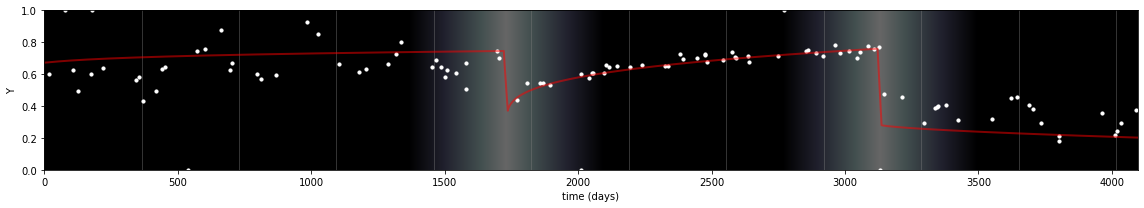

In [10]:
generate_one_figure(0)